In [ ]:
!pip install -q transformers datasets evaluate sentencepiece spacy geopy pandas matplotlib seaborn
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 127.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd

df = pd.read_csv("data/cnn_dailymail/train.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (287113, 3)


,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
df = df.dropna(subset=['article', 'highlights'])

df = df.drop_duplicates(subset=['article', 'highlights'])

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (284015, 3)


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = text.strip()
    return text

df['article'] = df['article'].apply(clean_text)
df['highlights'] = df['highlights'].apply(clean_text)

In [ ]:
from sklearn.model_selection import train_test_split

subset_df = df.sample(frac=0.10, random_state=42)
train_df, val_df = train_test_split(subset_df[['article','highlights']], test_size=0.02, random_state=42)

train_df = train_df.rename(columns={'article':'text','highlights':'summary'})
val_df = val_df.rename(columns={'article':'text','highlights':'summary'})

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

Train shape: (27833, 2)
Validation shape: (569, 2)


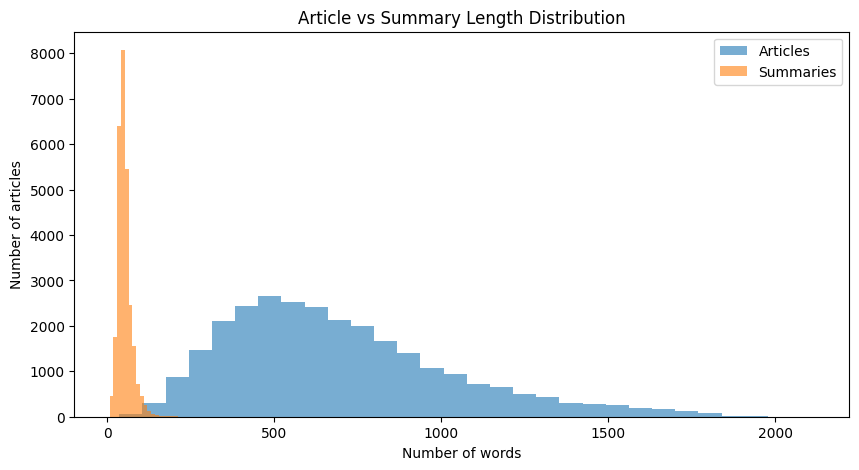

In [ ]:
import matplotlib.pyplot as plt

article_lengths = train_df['text'].str.split().str.len()
summary_lengths = train_df['summary'].str.split().str.len()

plt.figure(figsize=(10,5))
plt.hist(article_lengths, bins=30, alpha=0.6, label='Articles')
plt.hist(summary_lengths, bins=30, alpha=0.6, label='Summaries')
plt.xlabel("Number of words")
plt.ylabel("Number of articles")
plt.title("Article vs Summary Length Distribution")
plt.legend()
plt.show()

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")
max_input_length = 512
max_target_length = 150

def preprocess(examples):
    inputs = ["summarize: " + text for text in examples['text']]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/27833 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/569 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="t5_small_finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    num_train_epochs=1,
    logging_steps=50,
    fp16=False,
    report_to=[],
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipython-input-3960453990.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Step,Training Loss
50,2.499300
100,2.182400
150,2.075100
200,2.246000
250,2.020700
300,2.158400
350,2.247500
400,2.203700
450,2.198800
500,2.088000


TrainOutput(global_step=13917, training_loss=2.0566996438515086, metrics={'train_runtime': 2741.6686, 'train_samples_per_second': 10.152, 'train_steps_per_second': 5.076, 'total_flos': 3756830942232576.0, 'train_loss': 2.0566996438515086, 'epoch': 1.0})

In [ ]:
def generate_summary(texts, max_length=150):
    inputs = tokenizer(
        ["summarize: " + t for t in texts],
        max_length=512,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_length=max_length, num_beams=4, early_stopping=True)
    return [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]

sample_texts = df['article'][:100].tolist()
generated_summaries = generate_summary(sample_texts)

for i, summary in enumerate(generated_summaries, 1):
    print(f"{i}. {summary}\n")


1. Bishop John Folda of the Fargo Catholic Diocese in North Dakota has exposed hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month.

2. Ralph Mata is an internal affairs lieutenant for the Miami-Dade Police Department. Authorities allege Mata used his role as a police officer to help plan a murder plot. Mata, 45, faces charges of aiding and abetting a conspiracy to distribute cocaine.

3. Craig Eccleston-Todd, 27, was driving home from a pub night when he received a text. He veered across the road while driving and smashed into Rachel Titley's car. Rachel Titley, 28, was pulled the wreckage of her Daihatsu Cuore but died in hospital. He was found guilty of causing death by dangerous driving at Portsmouth Crown Court.

4. Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the re

In [ ]:
import spacy
from geopy.geocoders import Nominatim

nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="geo_pipeline")

def extract_locations(text):
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    coords = []
    for loc in locations:
        try:
            geo = geolocator.geocode(loc)
            if geo:
                coords.append((geo.latitude, geo.longitude))
            else:
                coords.append((None, None))
        except:
            coords.append((None, None))
    return locations, coords

all_locations = []
all_coords = []

for summ in generated_summaries:
    locs, coords = extract_locations(summ)
    all_locations.append(locs)
    all_coords.append(coords)

In [ ]:
final_df = pd.DataFrame({
    "article": sample_texts,
    "summary": generated_summaries,
    "locations": all_locations,
    "coordinates": all_coords
})

final_df.to_csv("summaries_geotagged.csv", index=False)
print("Saved summaries_geotagged.csv")

Saved summaries_geotagged.csv


In [ ]:
!pip install rouge_score
import evaluate

rouge = evaluate.load("rouge")

refs = df['highlights'][:100].tolist()
preds = generated_summaries

results = rouge.compute(predictions=preds, references=refs)
print("ROUGE Scores:", results)

ROUGE Scores: {'rouge1': np.float64(0.36433252906613045), 'rouge2': np.float64(0.18175041149825036), 'rougeL': np.float64(0.2791625747332639), 'rougeLsum': np.float64(0.2776639725930379)}


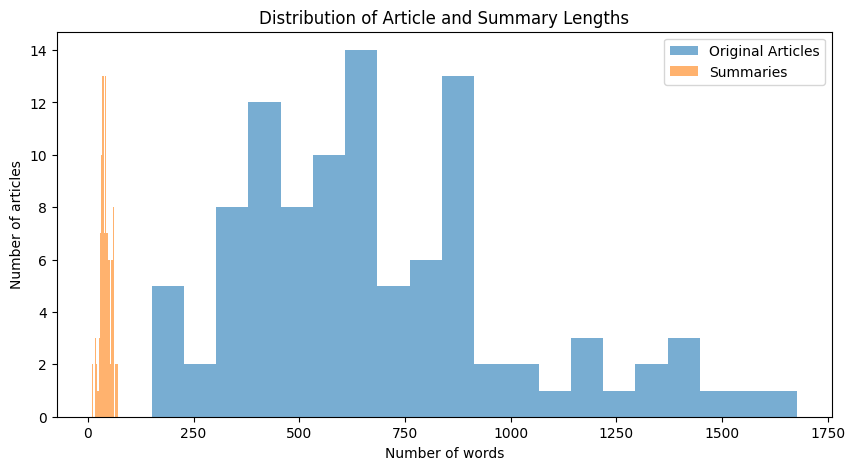

In [ ]:
import matplotlib.pyplot as plt

article_lengths = [len(a.split()) for a in final_df['article']]
summary_lengths = [len(s.split()) for s in final_df['summary']]

plt.figure(figsize=(10,5))
plt.hist(article_lengths, bins=20, alpha=0.6, label="Original Articles")
plt.hist(summary_lengths, bins=20, alpha=0.6, label="Summaries")
plt.xlabel("Number of words")
plt.ylabel("Number of articles")
plt.title("Distribution of Article and Summary Lengths")
plt.legend()
plt.show()

In [ ]:
#QA Implementation Using Generated Summaries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import T5Tokenizer, T5ForConditionalGeneration


In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
df = pd.read_csv("summaries_geotagged.csv")

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["summary"])

In [ ]:
def retrieve_context(question, top_k=1):
    q_vec = vectorizer.transform([question])
    sims = cosine_similarity(q_vec, X).flatten()
    top_idx = sims.argsort()[-top_k:][::-1]
    return " ".join(df.iloc[top_idx]["summary"].values)

In [ ]:
def rag_qa(question):
    context = retrieve_context(question, top_k=1)
    input_text = f"question: {question}  context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs["input_ids"], max_length=100, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True), context

In [ ]:
while True:
    q = input("Ask a question (or type quit): ")
    if q.lower() == "quit":
        break
    ans, ctx = rag_qa(q)
    print(f"\nAnswer: {ans}\n(Context used: {ctx[:200]}...)\n")

Ask a question (or type quit): What crime or incident is described?

Answer: Hispanic
(Context used: The thieves stole an iPad from a canoe rental office in Wekiva, Florida. The pair were caught on security cameras picking the tablet computer, worth $700. One suspect is described as being Hispanic wi...)

Ask a question (or type quit): Who is the victim or target?

Answer: police
(Context used: Police have reviewed hundreds of online postings over alleged anti-cop threats. edwards: Suppose I posted that I planned to "swarm on any m... in a blue uniform," meaning specifically the police....)

Ask a question (or type quit): When did the incident happen?

Answer: October
(Context used: Pilots did not fall asleep when they overflew their destination by more than 100 miles in October. They did not communicate with air traffic control for about 1 hour and 17 minutes. The NTSB report gi...)

Ask a question (or type quit): Who was Ralph Mata?

Answer: internal affairs lieutenant
(Context used: